<a href="https://colab.research.google.com/github/thesighsrikar/DL1_CAMVID/blob/master/CAMVID_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Importing the dataset and dependencies

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *

Dataset: Brostow, Gabriel J., Jamie Shotton, Julien Fauqueur and Roberto Cipolla. “Segmentation and Recognition Using Structure from Motion Point Clouds.” ECCV (2008). 

[Click here to download](https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz)

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

# Exploration

camvid


*   images
    *   0001TP_006690.png
    *   0001TP_006720.png
*   labels
    *   0001TP_006690_P.png
    *   0001TP_006720_P.png
*   codes.txt
*   valid.txt




In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[ :3] #First three images: 0,1,2

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f01560.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02640.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_007830.png')]

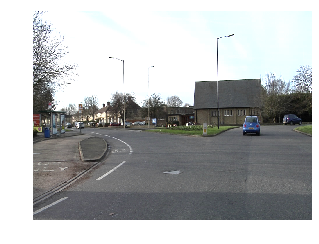

In [0]:
img = open_image(fnames[0])
img.show(figsize=(5,5))

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3] #First three labels: 0,1,2

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_008340_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008250_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_02370_P.png')]

Function that converts from the image file names to the equivalent label file names.

Converting Image file names to equivalent label names: 'File Name' + '_P' is the aim of the function. And passing this result to open an image. Thus the mask of the corresponding is opened.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

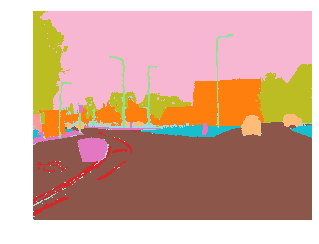

In [0]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:]) #First row and all the columns
src_size

array([720, 960])

In [0]:
mask.data

tensor([[[26, 26, 26,  ..., 21, 21, 21],
         [26, 26, 26,  ..., 21, 21, 21],
         [26, 26, 26,  ..., 21, 21, 21],
         ...,
         [30, 17, 17,  ..., 17, 17, 17],
         [30, 30, 17,  ..., 17, 17, 17],
         [30, 30, 30,  ..., 17, 17, 17]]])

code.txt contains a list telling us that, for example, number 4 isbuilding.

# Processing the dataset

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We're going to do a little classification problem for every single pixel in every single image. That's called segmentation. I can create our data bunch. I'm using a smaller batch size (bs=8) because, as you can imagine, I'm creating a classifier for every pixel, that's going to take a lot more GPU right. I found a batch size of 8 is all I could handle. Then normalize in the usual way.

In [0]:
size = src_size//2
bs = 8

To create a data bunch, we can go through the data block API and say:

    We've got a list of image files that are in a folder.
    
    We then need to split into training and validation. In this case I don't do it randomly because the pictures they've given us are frames from videos. If I did them randomly I would be having two frames next to each other: one in the validation set, one in the training set. That would be far too easy and treating. So the people that created this dataset actually gave us a list of file names (valid.txt) that are meant to be in your validation set and they are non-contiguous parts of the video. So here's how you can split your validation and training using a file name file.

    We need to create labels which we can use that get_y_fn (get Y file name function) we just created .

In [0]:
src = (SegmentationItemList.from_folder(path_img) #Where are the images?
       .split_by_fname_file('../valid.txt') # Split some to validation dataset. But here, the .txt files has the names of the images which has to be in valid_ds
       .label_from_func(get_y_fn, classes=codes)) # How are we going to label them?

What if we randomly flip the independent variable image but we don't also randomly flip the target mask? Now I'm not matching anymore. So we need to tell fastai that I want to transform the Y (X is our independent variable: image, Y is our dependent: mask)﹣I want to transform the Y as well. So whatever you do to the X, I also want you to do to the Y (***tfm_y=True***). 

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs, num_workers=0)
       .normalize(imagenet_stats))

astai knows that you've given it a segmentation problem, when you call show batch, it actually combines the two pieces for you and it will color code the photo. So this is what the ground truth data looks.

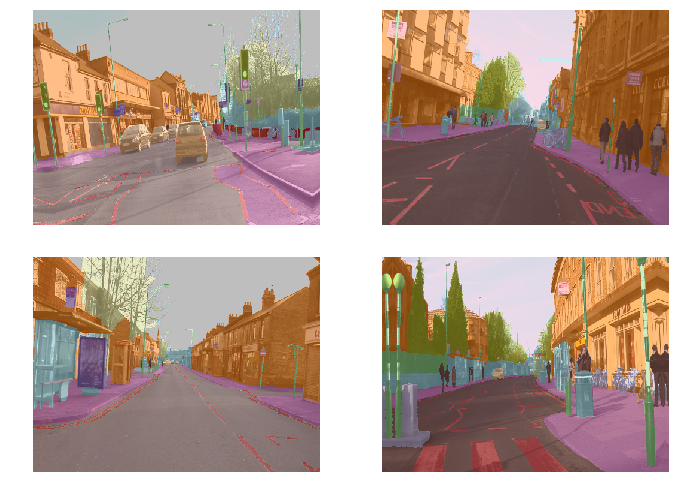

In [0]:
data.show_batch(2, figsize=(10,7))

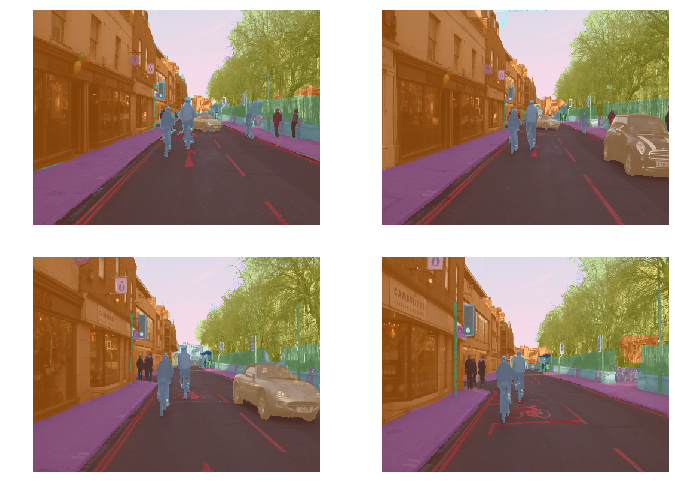

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Training the dataset

So you actually we can just pass in accuracy as our metric, but in this case, we actually don't. We've created a new metric called ***acc_camvid*** and the reason for that is that when they labeled the images, sometimes they labeled a pixel as Void. And in the CamVid paper, they say when you're reporting accuracy, you should remove the void pixels. So we've created accuracy CamVid. So all metrics take the actual output of the neural net 

We then basically create a mask (we look for the places where the target is not equal to Void) and then we just take the input, do the argmax as per usual, but then we just grab those that are not equal to the void code. We do the same for the target and we take the mean, so it's just a standard accuracy.

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

 accuracy for pixel wise segmentation: correctly classified pixels / #total number of pixels
 
 

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 117994405.46it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


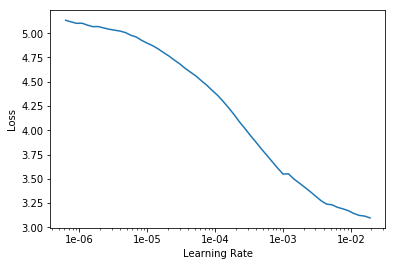

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = slice(1e-06,1e-03)

In [0]:
learn.fit_one_cycle(10, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.657876,1.019211,0.766817,04:24
1,1.036873,0.752302,0.817019,04:13
2,0.770475,0.615197,0.840750,04:14
3,0.662096,0.538674,0.851975,04:15
4,0.592194,0.485521,0.865086,04:14
5,0.561942,0.456824,0.862072,04:14
6,0.565739,0.537621,0.863512,04:14
7,0.522807,0.402169,0.881117,04:12
8,0.482420,0.383617,0.893633,04:12
9,0.408606,0.323375,0.901555,04:12


In [0]:
path = "."

In [0]:
learn.save('stage-1')

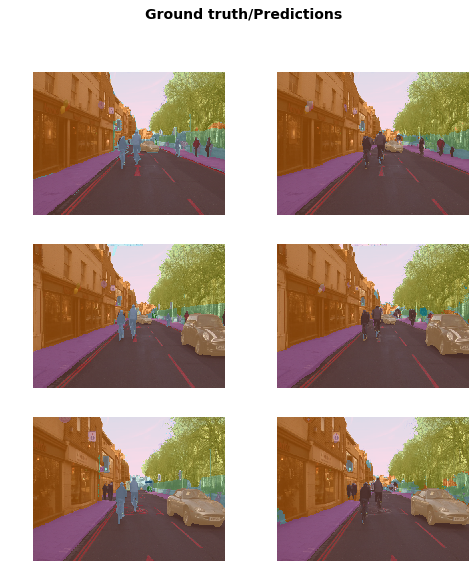

In [0]:
learn.show_results(rows=3, figsize=(8,9))

# Analysis, fine-tuning and training the model again

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


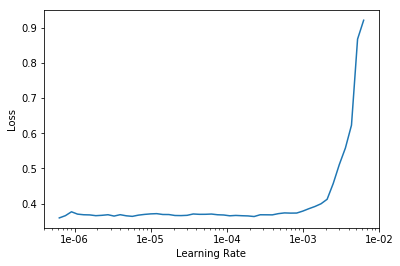

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.356708,0.319669,0.898747,04:19
1,0.349540,0.308611,0.903786,04:19
2,0.347067,0.303984,0.907457,04:19
3,0.341747,0.299362,0.911737,04:20
4,0.329639,0.290544,0.915433,04:20
5,0.318006,0.302190,0.910377,04:20
6,0.313336,0.303656,0.908871,04:20
7,0.306229,0.292797,0.915422,04:20
8,0.294177,0.303943,0.907526,04:20
9,0.286775,0.292076,0.915917,04:20


In [0]:
learn.save('stage-2')